In [9]:
import os


os.chdir(str(globals()["_dh"][0]).removesuffix("/statistics"))
print(os.getcwd())

import pickle
import matplotlib.pyplot as plt
import gzip
import yaml
import numpy as np

from Statistics import StatSaver, EpisodeStats
from Config import Config
from scipy.signal import savgol_filter

plt.style.use("seaborn-v0_8")


# Load config file
with open("config.yml", "r") as file:
    global config
    config = Config(yaml.safe_load(file.read()))

loaded_stats: list[EpisodeStats] = StatSaver.load_all_statistics(config.statistics_filename)

/home/riccardo/AAS


In [10]:
num_episodes = len(loaded_stats)

episodes_number = []
episodes_winner = []
episodes_winner_hp_remaining = []

episodes_total_reward = []
episodes_total_actions = []

# For each episode
for episode_stat in loaded_stats:
    # Episode Number
    episodes_number.append(episode_stat.episode_number)

    # Episode Winner
    episodes_winner.append(episode_stat.winner_name)

    # Episode Winner HP
    episodes_winner_hp_remaining.append(episode_stat.winner_hp_remaining)

    total_reward = {}  # agentName, total episode reward
    total_actions = {}  # agentName, dict[actionName, count]

    # For each step
    for agentName, action_taken, reward in episode_stat.step_stats:  # step_stat: (agentName, action_taken, reward)
        # Total reward
        if agentName not in total_reward:  # if agent doesn't exist yet
            total_reward[agentName] = 0
        total_reward[agentName] += reward

        # Total count of actions
        if agentName not in total_actions:  # if agent doesn't exist yet
            total_actions[agentName] = {}

        if action_taken not in total_actions[agentName]:  # if action doesn't exist yet
            total_actions[agentName][action_taken] = 0

        total_actions[agentName][action_taken] += 1

    episodes_total_reward.append(total_reward)
    episodes_total_actions.append(total_actions)

In [11]:
all_actions = set().union(
    *[actions[agentName].keys() for actions in episodes_total_actions for agentName in actions.keys()]
)
episodes_number_np = np.array(episodes_number).reshape(-1, 1)
num_actions = len(all_actions)

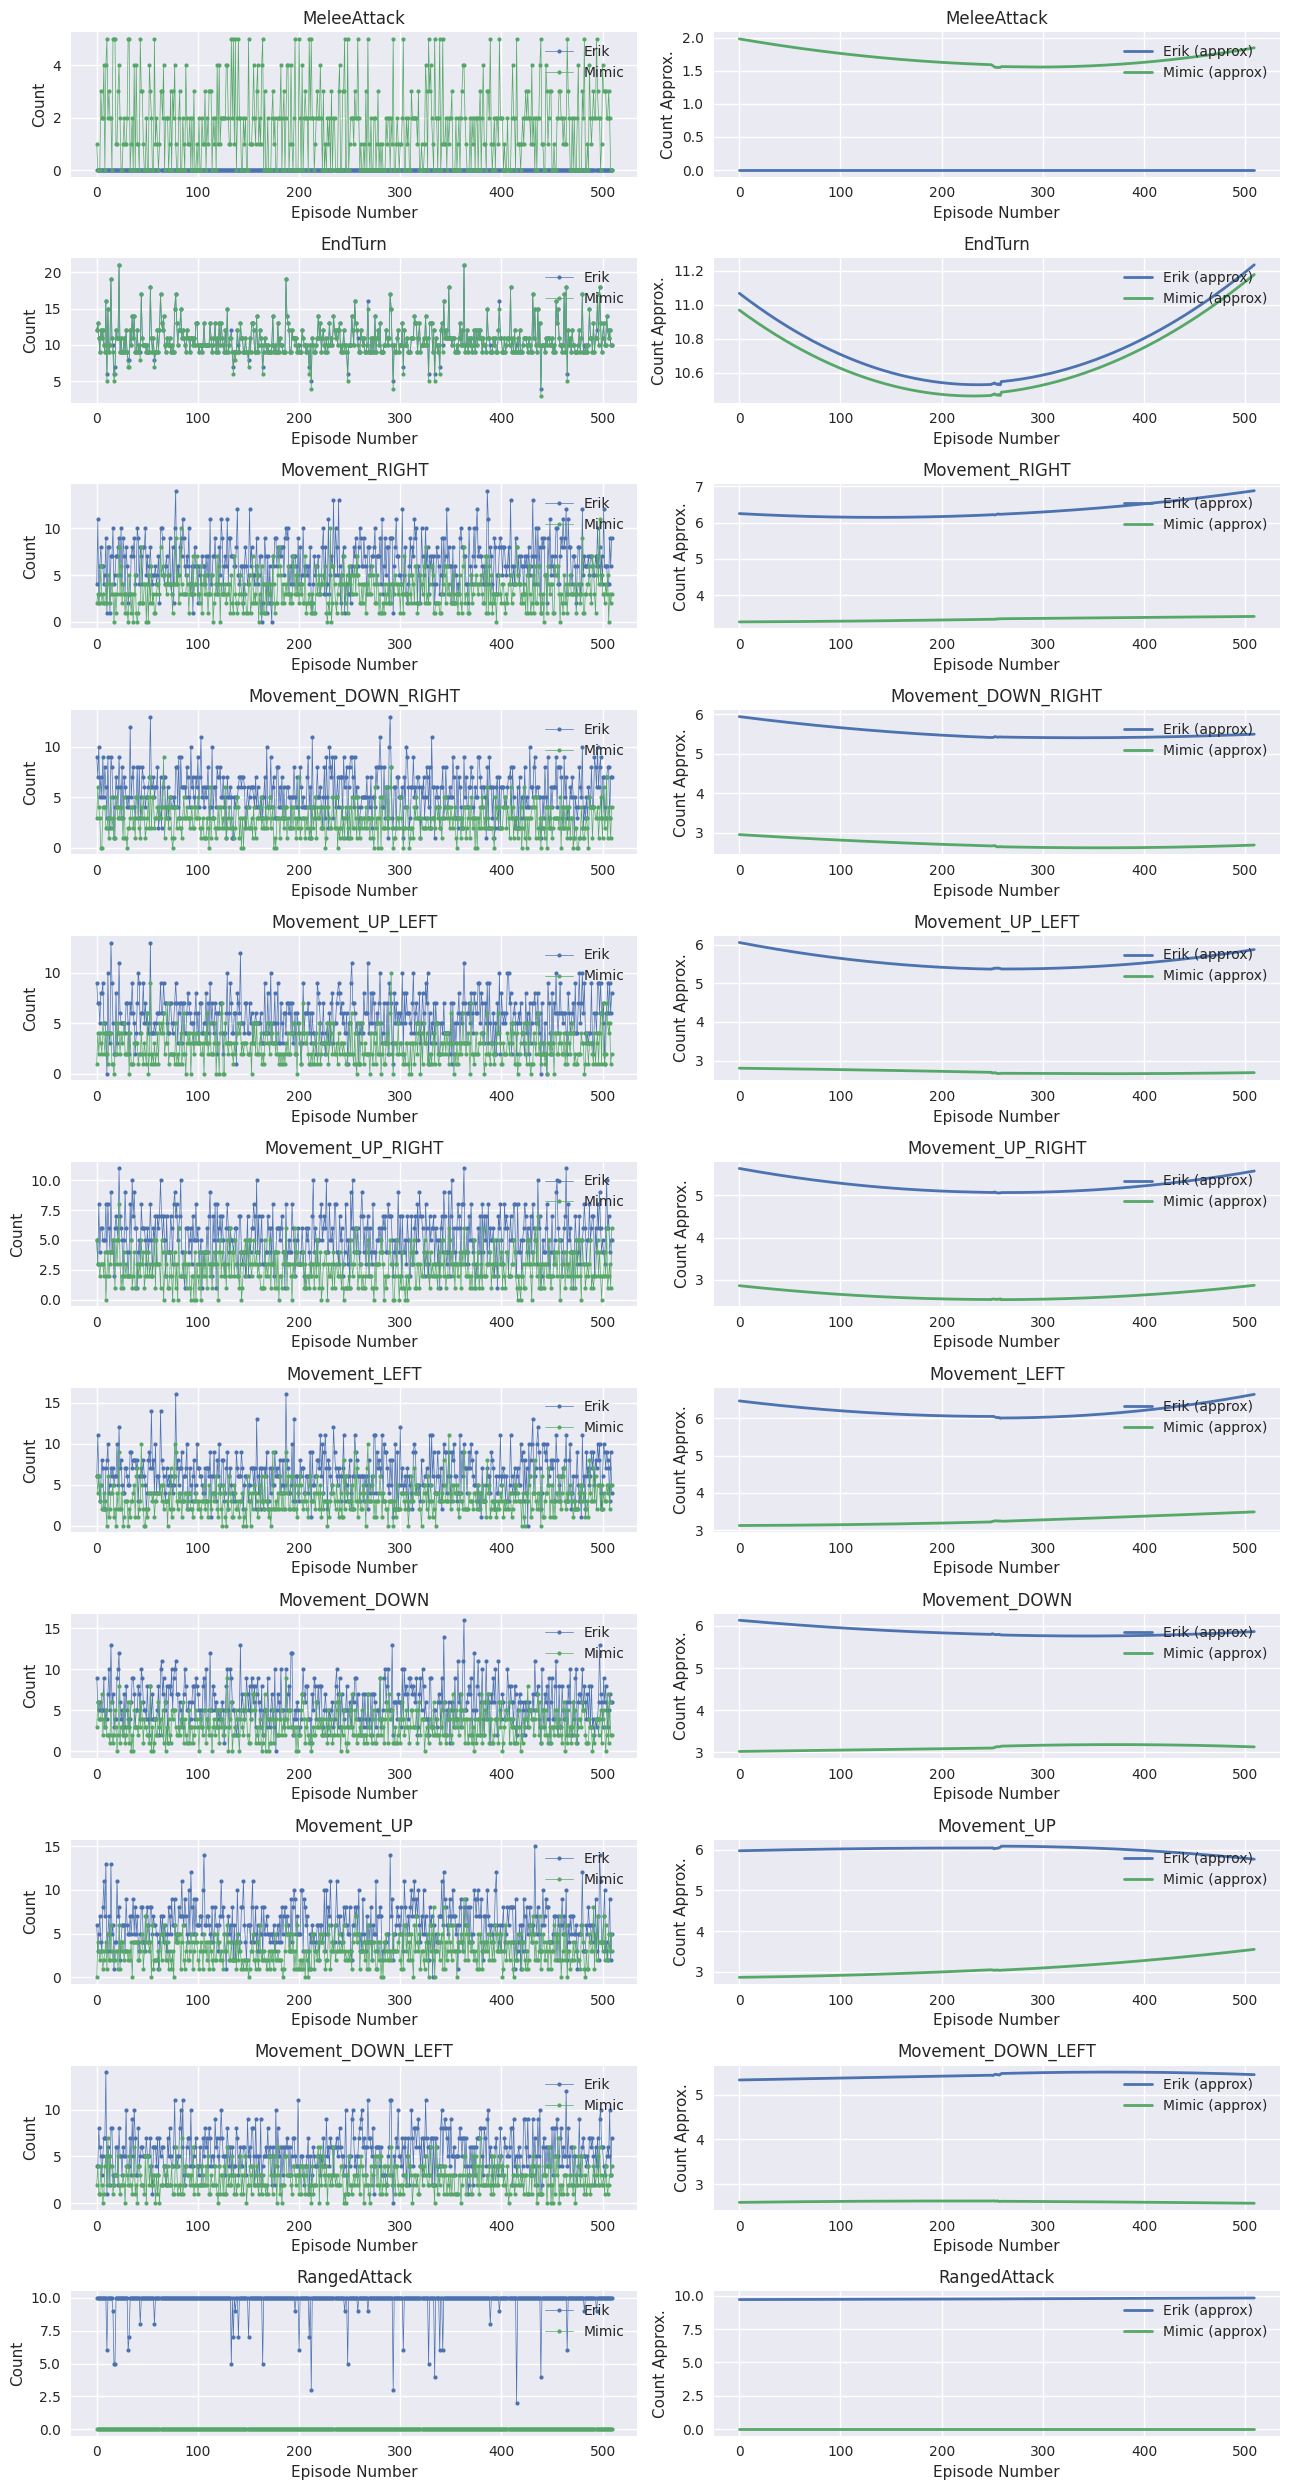

In [12]:
fig, axs = plt.subplots(num_actions, 2, figsize=(13, 25))
axs = axs.ravel()
# For each action
for i, action in enumerate(all_actions):
    # For each agent
    for agentName in episodes_total_actions[0].keys():  # (get agents name from first episode)
        # Entire plot of points
        action_count = [actions[agentName].get(action, 0) for actions in episodes_total_actions]
        axs[2 * i].plot(episodes_number, action_count, "-o", linewidth=0.5, markersize=3, label=agentName)

        # Smoothed data
        smoothed_data = savgol_filter(action_count, window_length=500, polyorder=2)
        axs[2 * i + 1].plot(episodes_number, smoothed_data, label=f"{agentName} (approx)", linewidth=2)

    axs[2 * i].set_title(f"{action}")
    axs[2 * i].set_xlabel("Episode Number")
    axs[2 * i].set_ylabel("Count")
    axs[2 * i].legend(loc="upper right")
    axs[2 * i + 1].set_title(f"{action}")
    axs[2 * i + 1].set_xlabel("Episode Number")
    axs[2 * i + 1].set_ylabel("Count Approx.")
    axs[2 * i + 1].legend(loc="upper right")

plt.tight_layout()
plt.show()

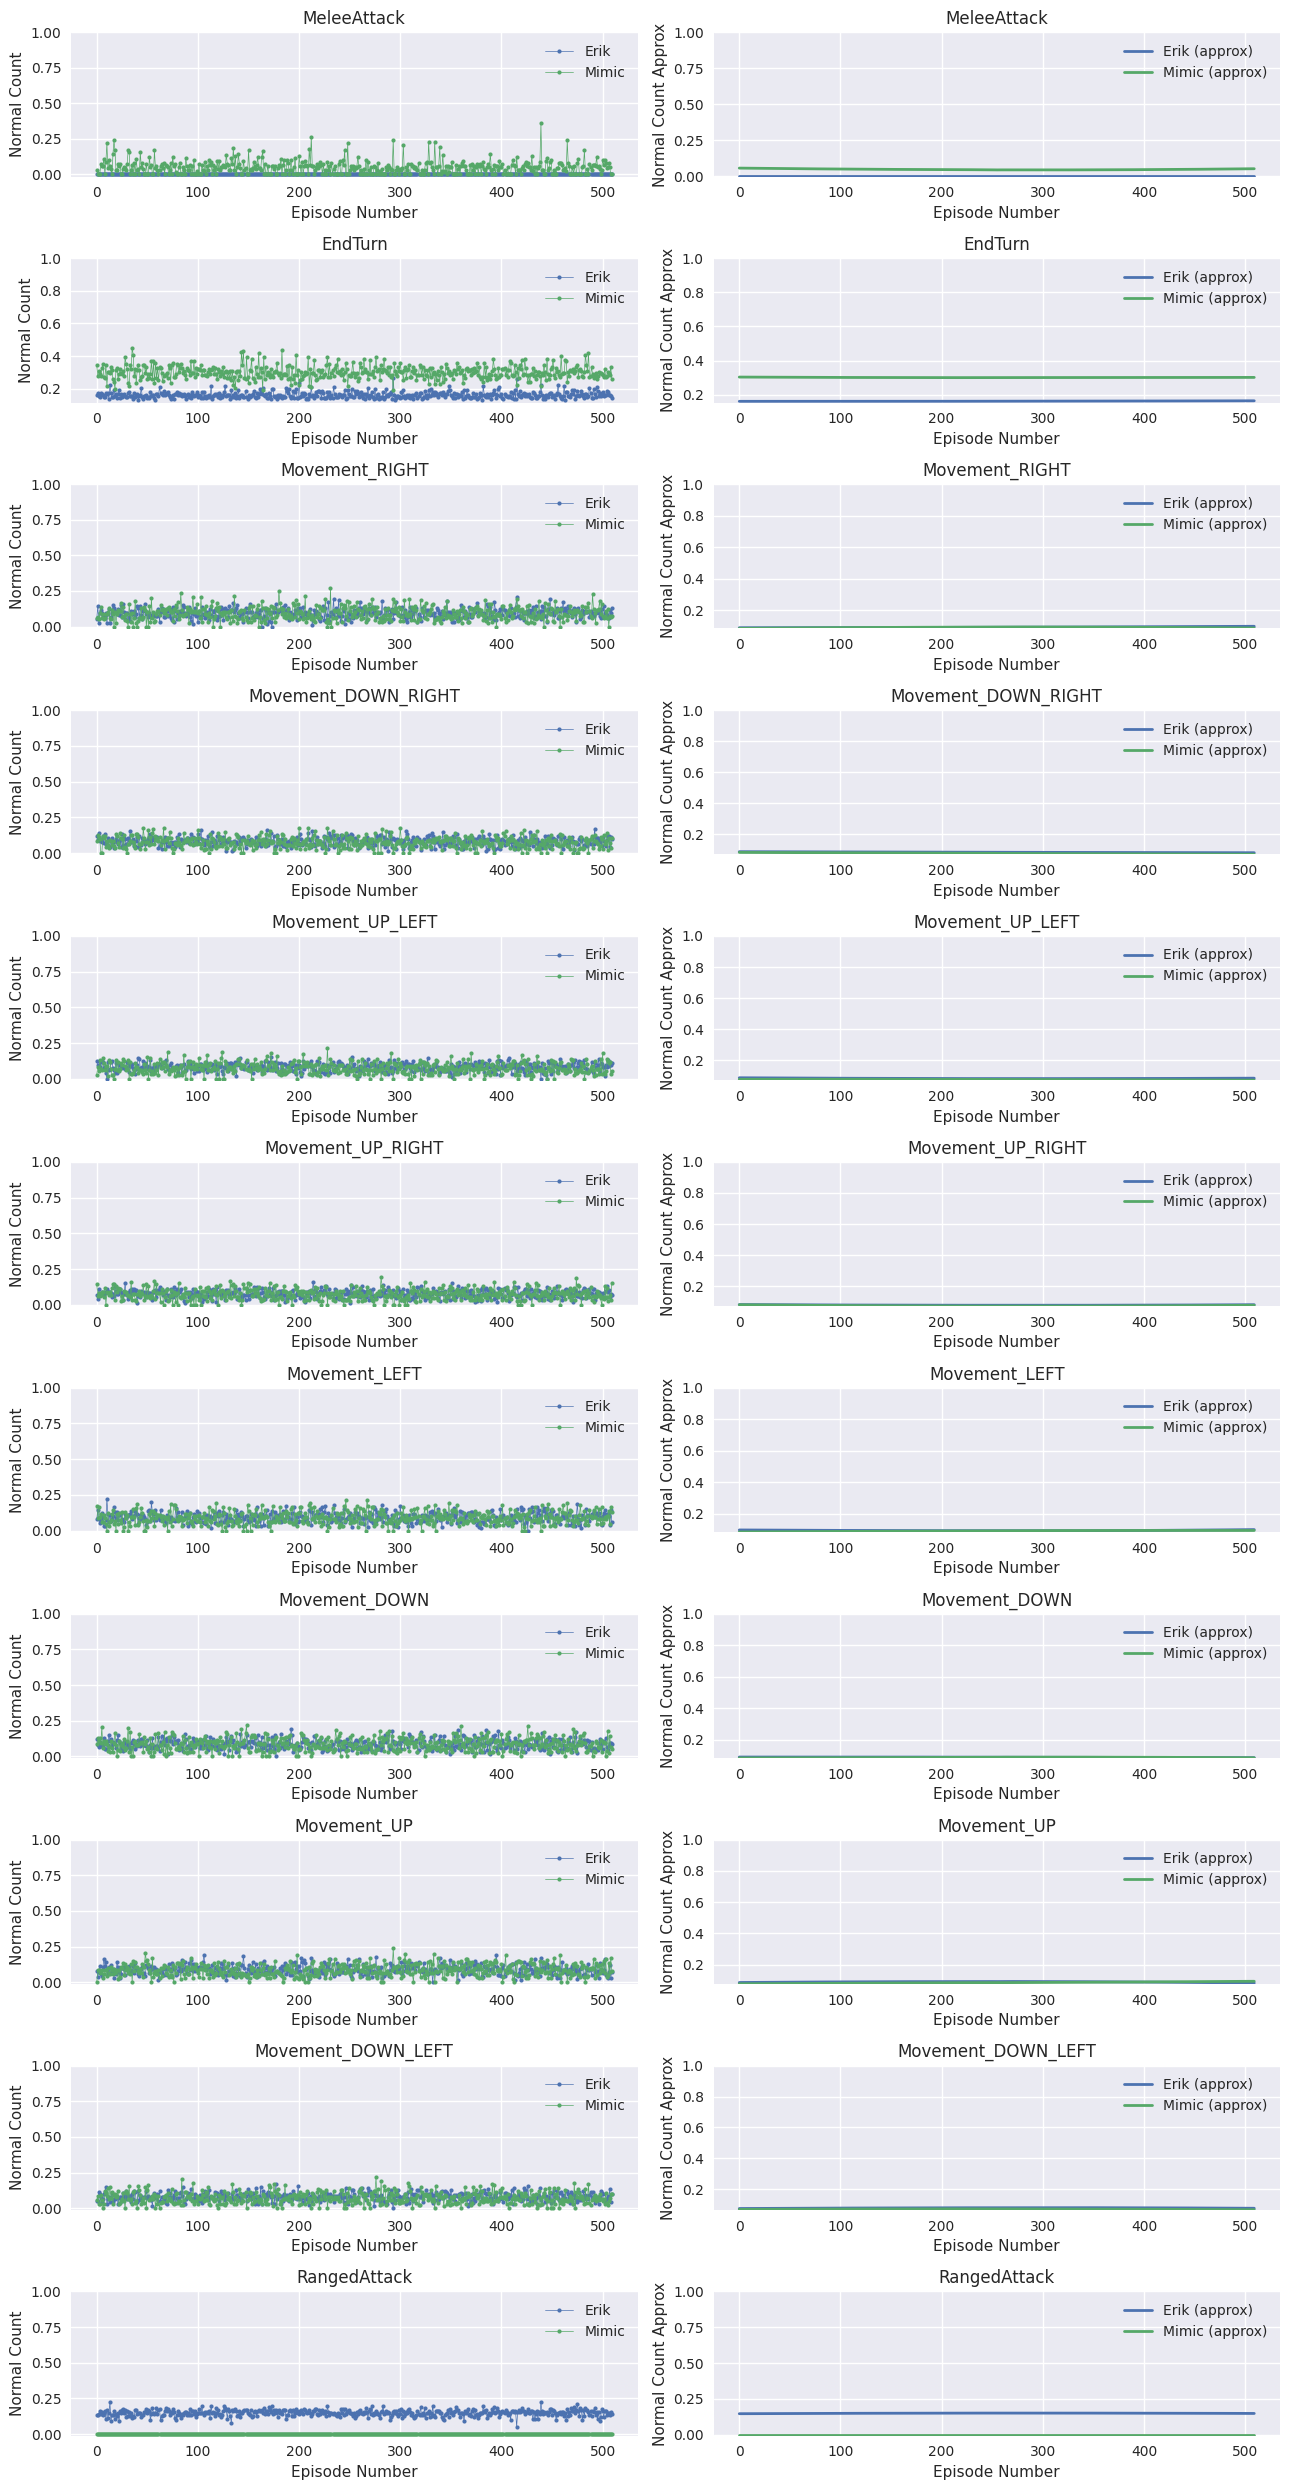

In [13]:
fig, axs = plt.subplots(num_actions, 2, figsize=(13, 25))
axs = axs.ravel()
# For each action
for i, action in enumerate(all_actions):
    # For each agent
    for agentName in episodes_total_actions[0].keys():  # (get agents name from first episode)

        # Get total number of actions taken in each episode by this agent
        total_actions_per_episode = [
            sum(actions[agentName].values()) if agentName in actions else 0 for actions in episodes_total_actions
        ]
        # Number of this action taken in each episode by this agent
        action_count = [
            actions[agentName].get(action, 0) if agentName in actions else 0 for actions in episodes_total_actions
        ]
        # Normalizing
        normalized_action_data = [
            action_count / total_actions if total_actions > 0 else 0
            for action_count, total_actions in zip(action_count, total_actions_per_episode)
        ]

        # Entire plot of points
        axs[2 * i].plot(episodes_number, normalized_action_data, "-o", linewidth=0.5, markersize=3, label=agentName)

        # Smoothed data
        smoothed_data = savgol_filter(normalized_action_data, window_length=500, polyorder=2)
        axs[2 * i + 1].plot(episodes_number, smoothed_data, label=f"{agentName} (approx)", linewidth=2)

    axs[2 * i].set_title(f"{action}")
    axs[2 * i].set_xlabel("Episode Number")
    axs[2 * i].set_ylabel("Normal Count")
    axs[2 * i].set_ylim(top=1)
    axs[2 * i].legend(loc="upper right")
    axs[2 * i + 1].set_title(f"{action}")
    axs[2 * i + 1].set_xlabel("Episode Number")
    axs[2 * i + 1].set_ylabel("Normal Count Approx")
    axs[2 * i + 1].set_ylim(top=1)
    axs[2 * i + 1].legend(loc="upper right")

plt.tight_layout()
plt.show()

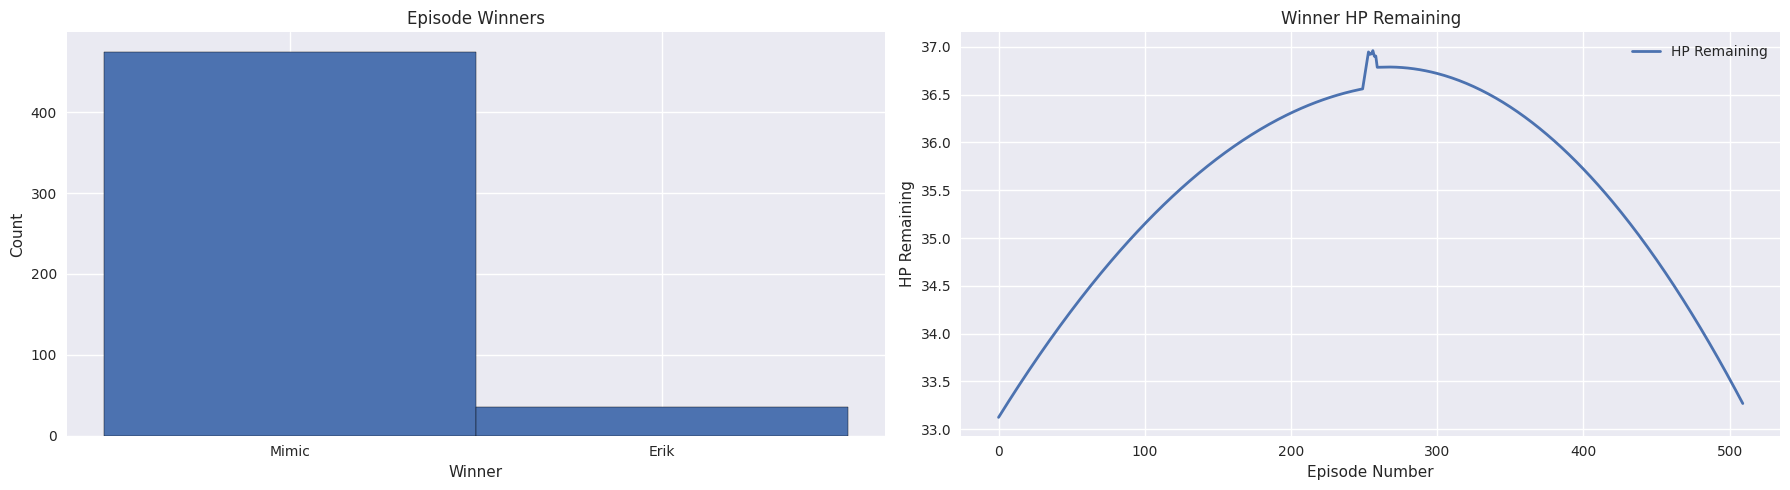

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(18, 5))
axs[0].hist(episodes_winner, bins=np.arange(len(set(episodes_winner)) + 1) - 0.5, edgecolor="black")
axs[0].set_title("Episode Winners")
axs[0].set_xlabel("Winner")
axs[0].set_ylabel("Count")
axs[0].set_xticks(np.arange(len(set(episodes_winner))))
axs[0].set_xticklabels(list(set(episodes_winner)))

# Smoothed data
smoothed_data = savgol_filter(episodes_winner_hp_remaining, window_length=500, polyorder=2)
axs[1].plot(episodes_number, smoothed_data, label="HP Remaining", linewidth=2)
axs[1].set_title("Winner HP Remaining")
axs[1].set_xlabel("Episode Number")
axs[1].set_ylabel("HP Remaining")
axs[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

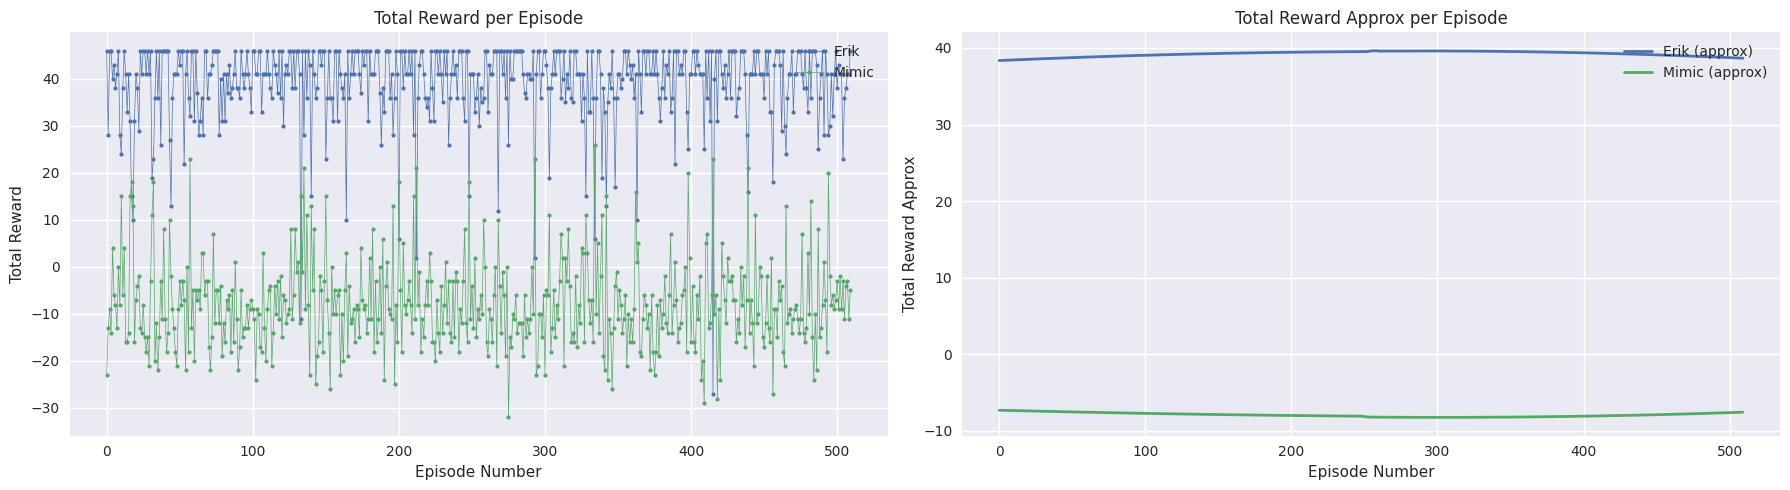

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(18, 5))
for agentName in episodes_total_reward[0].keys():
    total_reward_data = [reward[agentName] for reward in episodes_total_reward]
    axs[0].plot(episodes_number, total_reward_data, "-o", linewidth=0.5, markersize=3, label=agentName)
axs[0].set_title("Total Reward per Episode")
axs[0].set_xlabel("Episode Number")
axs[0].set_ylabel("Total Reward")
axs[0].legend(loc="upper right")

for agentName in episodes_total_reward[0].keys():
    total_reward_data = [reward[agentName] for reward in episodes_total_reward]

    smoothed_data = savgol_filter(total_reward_data, window_length=500, polyorder=2)
    axs[1].plot(episodes_number, smoothed_data, label=f"{agentName} (approx)", linewidth=2)

axs[1].set_title("Total Reward Approx per Episode")
axs[1].set_xlabel("Episode Number")
axs[1].set_ylabel("Total Reward Approx")
axs[1].legend(loc="upper right")

plt.tight_layout()
plt.show()